# Huffman Ternary Tree

This notebook shows how to generate a Huffman-code Ternary Tree as described by: 

[Li, Q. S., Liu, H. Y., Wang, Q., Wu, Y. C., & Guo, G. P. (2025). Huffman-Code-based Ternary Tree Transformation. Chinese Physics Letters.](http://iopscience.iop.org/article/10.1088/0256-307X/42/10/100001)

In [1]:
import pickle
from ferrmion.encode import TernaryTree
from pathlib import Path
from ferrmion.encode import TernaryTree
from ferrmion.encode.ternary_tree_node import TTNode
from pathlib import Path
import numpy as np

def water_integrals():
    folder = Path.cwd().joinpath(Path("../../../python/tests/"))
    with open(folder.joinpath("./data/water_1e.pkl"), 'rb') as file:
        ones = pickle.load(file)

    with open(folder.joinpath("./data/water_2e.pkl"), 'rb') as file:
        twos = pickle.load(file)
    return (ones, twos)

ones, twos = water_integrals()

## Majorana Frequency

First we need to find the weighting of majorana operators, "frequency" in the language of huffman codes.

For some hamiltonian $H= \sum_l h_l$, such as the Molecular Structure Hamiltonian:
$$H = \sum_{i,j} h_{ij}a^{\dagger}_i a_j + \sum_{i,j,k,l} h_{ijkl}a^{\dagger}_i a^{\dagger}_j a_k a_l $$

We define the frequency of a majorana operator as:

$$F_j = \sum_l I_l(j)|h_l|$$

$I_l(j)=1$ iff $m_j \in H_l$

In [2]:
n_modes = ones.shape[0] 
majorana_freq = np.zeros(n_modes)

for i in range(n_modes):
    for j in range(n_modes):
        val = np.abs(ones[i,j])
        positions = {i,j}
        for p in positions:
            majorana_freq[p]+=val

for i in range(n_modes):
    for j in range(n_modes):
        for k in range(n_modes):
            for l in range(n_modes):        
                val = np.abs(twos[i,j,k,l])
                positions = {i,j,k,l}
                for p in positions:
                    majorana_freq[p]+=val
majorana_freq = majorana_freq.repeat(2)

## Build the Tree

Now we can build the tree, using the huffman compression algorithm.

In [ ]:
nodes = {i: None for i in range(len(majorana_freq))}
weights = {i: j for i, j in enumerate(majorana_freq)}
n_ops = len(majorana_freq)
for i in range(n_ops // 2):
    parent_index = 2 * n_ops - 1 - i
    mins = sorted(weights.items(), key=lambda kv: (kv[1], kv[0]))[:3]

    parent = nodes.get(
        parent_index, TTNode(parent=None, qubit_label=i)
    )

    for min, child_string in zip(mins, ["x", "y", "z"][: len(mins)]):
        possible_child = nodes[min[0]]
        if isinstance(possible_child, TTNode):
            parent.add_child(which_child=child_string, child_node=possible_child)

    new_weight = 0
    for index, weight in mins:
        new_weight += weight
        weights.pop(index)
        nodes.pop(index)

    nodes[parent_index] = parent
    weights[parent_index] = new_weight

assert len(nodes) == 1
root_node = [*nodes.values()][0]


TypeError: TTNode.__init__() got an unexpected keyword argument 'root_path'

In [ ]:
huffman_tree = TernaryTree(n_modes=n_modes, root_node=root_node)
huffman_tree.enumeration_scheme = huffman_tree.default_enumeration_scheme()
huffman_tree.string_pairs

{'': ('xzz', 'yzzz'),
 'x': ('xxz', 'xyz'),
 'y': ('yyzz', 'yxz'),
 'xx': ('xxx', 'xxy'),
 'xy': ('xyy', 'xyx'),
 'xz': ('xzx', 'xzy'),
 'yx': ('yxy', 'yxx'),
 'yy': ('yyx', 'yyyz'),
 'yz': ('yzyz', 'yzxz'),
 'yyy': ('yyyy', 'yyyx'),
 'yyz': ('yyzx', 'yyzy'),
 'yzx': ('yzxy', 'yzxx'),
 'yzy': ('yzyx', 'yzyy'),
 'yzz': ('yzzy', 'yzzx')}

In [ ]:
huffman_tree.enumeration_scheme

{'': (13, 13),
 'x': (11, 11),
 'y': (12, 12),
 'xx': (5, 5),
 'xy': (6, 6),
 'xz': (7, 7),
 'yx': (8, 8),
 'yy': (9, 9),
 'yz': (10, 10),
 'yyy': (0, 0),
 'yyz': (1, 1),
 'yzx': (2, 2),
 'yzy': (3, 3),
 'yzz': (4, 4)}

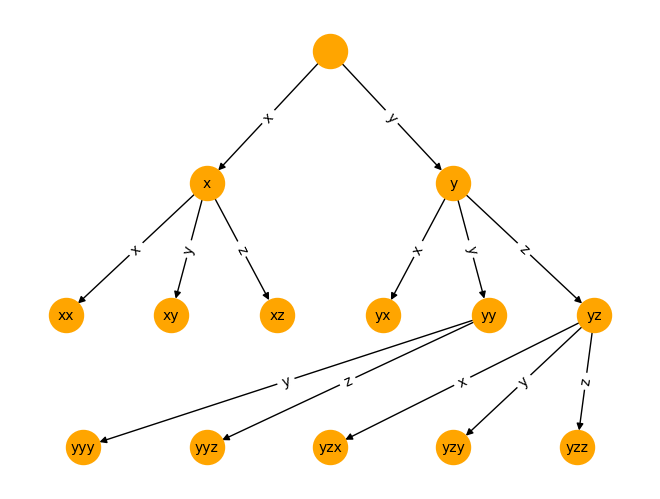

In [ ]:
from ferrmion.visualise import draw_tt
draw_tt(root_node)

## Redefining 2e frequency

Now that we have a tree structure, we need to assign fermionic modes to pairs of Pauli-strings derived from the structure of the tree.

We should account for how the operators interact, since we're aiming to find the minimal coefficient Pauli-weight.

To do this, we redefine the two-electron term frequency.

With a two electron term in the form $h_l = m_i m_j m_k m_l$

$$F_{ij}=\sum_l I_l(ij)|h_l|$$

$I_l(ij) = 1$ if $m_i$ and $m_j$ are in positons $(0,1)$ or $(2,3)$.

To simplify, we take the terms with $i<j$.

In [ ]:
n_modes = ones.shape[0] 
two_e_freq = np.zeros(ones.shape)
print(two_e_freq.shape)
for j in range(n_modes):
    for i in range(n_modes):
        for l in range(n_modes):        
            for k in range(n_modes):
                val = np.abs(twos[i,j,k,l])
                two_e_freq[i,j]+=val
                two_e_freq[k,l]+=val
two_e_freq = np.kron(two_e_freq, np.array([[1,1],[1,1]]))
two_e_freq = np.triu(two_e_freq, k=1)

(14, 14)


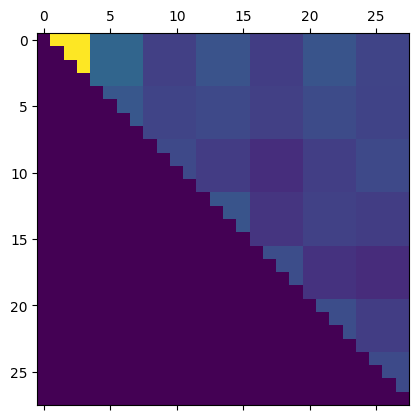

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(two_e_freq)

## Pairing Majorana operators to Pauli-strings

If we want to enforce vaccum state preservation (we do!), we require that we map majorana operators to paired strings.

This means we only need to use the freqencies of $i\in 0,2,4,6...N-1$ and let $j=i+1$

### Sorting Modes

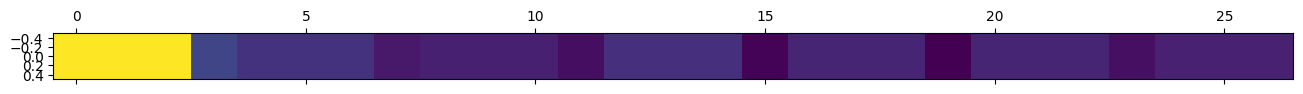

In [ ]:
vaccum_frequencies = np.diag(two_e_freq,k=1)
plt.matshow([vaccum_frequencies])
sorted_pairs = [(i,i+1) for i in np.argsort(vaccum_frequencies)[::-1] if i %2 ==0]
sorted_modes = [i[0]//2 for i in sorted_pairs]

### Sorting Operators

In [ ]:
from ferrmion.utils import pauli_to_symplectic, symplectic_product, find_pauli_weight

In [ ]:
weights = {}
for index, pair in enumerate(huffman_tree.string_pairs.values()):
    left, right = pair
    left = huffman_tree.branch_pauli_map[left]
    right = huffman_tree.branch_pauli_map[right]

    weights[index] = {}
    _, left = pauli_to_symplectic(0, left)
    _, right = pauli_to_symplectic(0, right)
    pair_weight = find_pauli_weight(np.array([left])) + find_pauli_weight(
        np.array([right])
    )
    _, product = symplectic_product(left, right)
    product_weight = find_pauli_weight(np.array([product]))

    weights[index]["pair_weight"] = pair_weight
    weights[index]["prod_weight"] = product_weight

    operator_order = sorted(
        weights.items(), key=lambda kv: (kv[1]["prod_weight"], kv[1]["pair_weight"])
    )

    operator_order = [index for index, _ in operator_order]

In [ ]:
huffman_tree.string_pairs

{'': ('xzz', 'yzzz'),
 'x': ('xxz', 'xyz'),
 'y': ('yyzz', 'yxz'),
 'xx': ('xxx', 'xxy'),
 'xy': ('xyy', 'xyx'),
 'xz': ('xzx', 'xzy'),
 'yx': ('yxy', 'yxx'),
 'yy': ('yyx', 'yyyz'),
 'yz': ('yzyz', 'yzxz'),
 'yyy': ('yyyy', 'yyyx'),
 'yyz': ('yyzx', 'yyzy'),
 'yzx': ('yzxy', 'yzxx'),
 'yzy': ('yzyx', 'yzyy'),
 'yzz': ('yzzy', 'yzzx')}

In [ ]:
huffman_tree.enumeration_scheme

{'': (13, 13),
 'x': (11, 11),
 'y': (12, 12),
 'xx': (5, 5),
 'xy': (6, 6),
 'xz': (7, 7),
 'yx': (8, 8),
 'yy': (9, 9),
 'yz': (10, 10),
 'yyy': (0, 0),
 'yyz': (1, 1),
 'yzx': (2, 2),
 'yzy': (3, 3),
 'yzz': (4, 4)}

In [ ]:
operator_order = sorted(weights.items(), key= lambda kv: (kv[1]["prod_weight"], kv[1]["pair_weight"]))
operator_order = [index for index, _ in operator_order]

### Assigning a mode-operator map

In [ ]:
mode_op_map = [0]* len(sorted_modes)
for operator_index, mode_index in enumerate(sorted_modes):
    mode_op_map[mode_index] = operator_order[operator_index]
huffman_tree.default_mode_op_map = mode_op_map
print(huffman_tree.enumeration_scheme)
huffman_tree.enumeration_scheme = huffman_tree.default_enumeration_scheme()
print(huffman_tree.enumeration_scheme)

{'': (13, 13), 'x': (11, 11), 'y': (12, 12), 'xx': (5, 5), 'xy': (6, 6), 'xz': (7, 7), 'yx': (8, 8), 'yy': (9, 9), 'yz': (10, 10), 'yyy': (0, 0), 'yyz': (1, 1), 'yzx': (2, 2), 'yzy': (3, 3), 'yzz': (4, 4)}
{'': (13, 13), 'x': (11, 11), 'y': (12, 12), 'xx': (5, 5), 'xy': (6, 6), 'xz': (7, 7), 'yx': (8, 8), 'yy': (9, 9), 'yz': (10, 10), 'yyy': (0, 0), 'yyz': (1, 1), 'yzx': (2, 2), 'yzy': (3, 3), 'yzz': (4, 4)}


In [ ]:
huffman_tree.default_enumeration_scheme()

{'': (13, 13),
 'x': (11, 11),
 'y': (12, 12),
 'xx': (5, 5),
 'xy': (6, 6),
 'xz': (7, 7),
 'yx': (8, 8),
 'yy': (9, 9),
 'yz': (10, 10),
 'yyy': (0, 0),
 'yyz': (1, 1),
 'yzx': (2, 2),
 'yzy': (3, 3),
 'yzz': (4, 4)}

## Coefficient Pauli Weight

Now we can find out how well the Huffman-tree reduces the coefficient Pauli-weight. 

In [ ]:
from ferrmion.hamiltonians import molecular_hamiltonian, molecular_hamiltonian_template
from ferrmion.optimize import pauli_weighted_norm

ham = molecular_hamiltonian(huffman_tree, ones, twos, constant_energy=0, physicist_notation=True)
pauli_weighted_norm(ham)

[np.float64(334.90060355987276)]

In [ ]:
from ferrmion.encode import JW, ParityEncoding, BK, JKMN
encoding_funcs = [JW, ParityEncoding, BK, JKMN]
for encoding in encoding_funcs:
    ham = molecular_hamiltonian(encoding(n_modes=huffman_tree.n_modes), ones, twos, constant_energy=0, physicist_notation=True)
    pw = pauli_weighted_norm(ham)
    print(encoding.__name__, pw)

JW [np.float64(272.4190655251233)]
ParityEncoding [np.float64(354.2305634781458)]
BK [np.float64(374.47515539593286)]
JKMN [np.float64(356.94521298138443)]


# Inbuilt Function

`ferrmion` provides a method to generate vaccum-preserving Huffman-code trees by providing one and two electron coefficents.

[np.float64(334.9006035598727)]

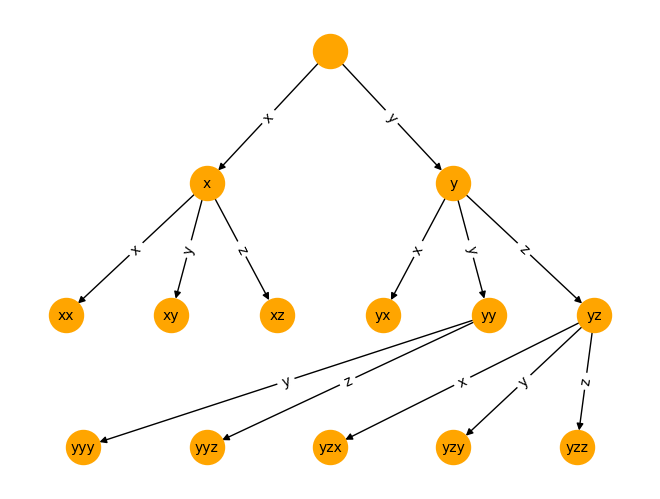

In [ ]:
from ferrmion.optimize.huffman import huffman_ternary_tree

inbuilt_huffman = huffman_ternary_tree(ones, twos)
draw_tt(inbuilt_huffman)

inbuilt_ham = molecular_hamiltonian(inbuilt_huffman, ones, twos, constant_energy=0, physicist_notation=True)
pauli_weighted_norm(inbuilt_ham)

In [ ]:
inbuilt_huffman.default_enumeration_scheme()

{'': (13, 13),
 'x': (11, 11),
 'y': (12, 12),
 'xx': (5, 5),
 'xy': (6, 6),
 'xz': (7, 7),
 'yx': (8, 8),
 'yy': (9, 9),
 'yz': (10, 10),
 'yyy': (0, 0),
 'yyz': (1, 1),
 'yzx': (2, 2),
 'yzy': (3, 3),
 'yzz': (4, 4)}

In [ ]:
inbuilt_huffman.as_dict() == huffman_tree.as_dict()

True